#Рекуррентные нейронные сети


Рассмотрим пример работы рекуррентных нейронных сетей на примере задачи о расшифровке сообщений.

Пусть нам даны сообщения, зашифрованные с помощью шифра Цезаря.

In [ ]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
key = 2
vocab = [char for char in ' -ABCDEFGHIJKLMNOPQRSTUVWXYZ']

###Функция зашифровки

In [ ]:
def encrypt(text, key):
  indexes = [vocab.index(char) for char in text]
  encrypted_indexes = [(key + idx) % len(vocab) for idx in indexes]
  encrypted_chars = [vocab[idx] for idx in encrypted_indexes]
  encrypted = ''.join(encrypted_chars)
  return encrypted

###Тестирование функции

In [ ]:
encrypt('MESSAGE', key)

'OGUUCIG'

Так как мы решаем задачу расшифровки, то особый интерес вызывает зависимость
индексов исходных символов от индексов зашифрованных символов. Постройте график
этой зависимости при значении ключа, равном 10

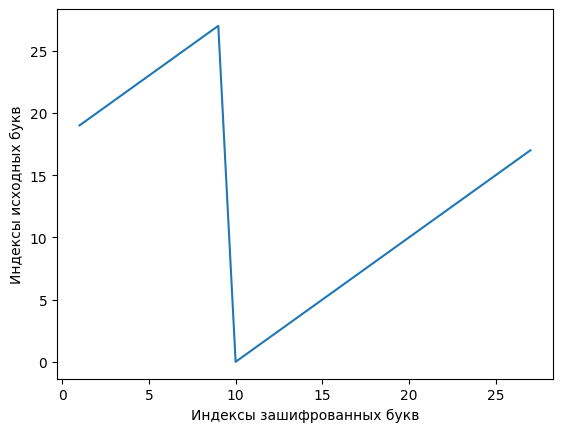

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
key = 10
plt.plot(range(1, len(vocab)), (np.arange(1, len(vocab)) - key) % len(vocab))
plt.ylabel('Индексы исходных букв')
plt.xlabel('Индексы зашифрованных букв')
plt.show()

## Датасет для обучения

Создадим dataset для решения задачи обучения с учителем. Он будет образован на
основе случайных фраз. Нам необходимо каждый символ представить в виде его индекса
в словаре, чтобы потом можно было воспользоваться эмбеддинг-слоем. Т.о. объектом
нашего dataset будет пара <тензор зашифрованного сообщения, тензор исходного
сообщения>. Количество объектов в dataset будет равно 256. Для простоты максимальную
длину сообщения возьмем равной 18.

In [ ]:
num_examples = 256
seq_len = 18
def encrypted_dataset(dataset_len, k):
  dataset = []
  for x in range(dataset_len):
    random_message = ''.join([random.choice(vocab) for _ in range(seq_len)])
    encrypt_random_message = encrypt(''.join(random_message), k)
    src = [vocab.index(char) for char in random_message]
    tgt = [vocab.index(char) for char in encrypt_random_message]
    dataset.append([torch.tensor(tgt), torch.tensor(src)])
  return dataset

In [ ]:
df = encrypted_dataset(num_examples, k=2)
example = df[0]

In [ ]:
example

[tensor([ 2,  9,  4, 17, 16, 23, 18,  7,  6,  1,  3, 24, 20, 24, 20,  6, 16, 16]),
 tensor([ 0,  7,  2, 15, 14, 21, 16,  5,  4, 27,  1, 22, 18, 22, 18,  4, 14, 14])]

## Модель

In [ ]:
class Decipher(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, rnn_type='simple'):

    super().__init__()
# слой эмбеддинга, параметры – количество эмбеддингов и размер эмбеддинга
    self.embed = nn.Embedding(num_embeddings=vocab_size,
    embedding_dim=embedding_dim)
    if rnn_type == 'simple':
# RNN: input_size – размер входа
      self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_dim,num_layers=num_layers)
# hidden_dim – размер входа, vocab_size – размер выхода, т.к. мы предсказываем вероятность всех символов
    self.fc = nn.Linear(hidden_dim, vocab_size)
    self.initial_hidden = torch.zeros(num_layers, 1, hidden_dim) # инициализируем нулями начальное скрытое состояние

  def forward(self, cipher):
# берем индексы символов в сообщении и подаем на слой эмбеддинга, эмбеддинг передаем в RNN
# CHECK INPUT SIZE
# Unsqueeze 1 dimension for batches
    embd_x = self.embed(cipher).unsqueeze(1)
    out_rnn, hidden = self.rnn(embd_x, self.initial_hidden)
    return self.fc(out_rnn).transpose(1, 2) # out_rnn – это конкатенация всех hidden с последнего слоя
# fc – это линейный слой, с его помощью мы для каждого символа, который мы зашифровали, предсказываем символ, который должен быть в исходном тексте

Инициируем параметры модели:

In [ ]:
embedding_dim = 5
hidden_dim = 10
num_layers=2
vocab_size = len(vocab)
lr = 1e-3
criterion = torch.nn.CrossEntropyLoss()
model = Decipher(vocab_size, embedding_dim, hidden_dim, num_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
num_epochs = 7

Посчитаем количество обучаемых параметров сети:

In [ ]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
count_parameters(model)

838

### Обучение

Epoch: 0
Loss: 2.8057


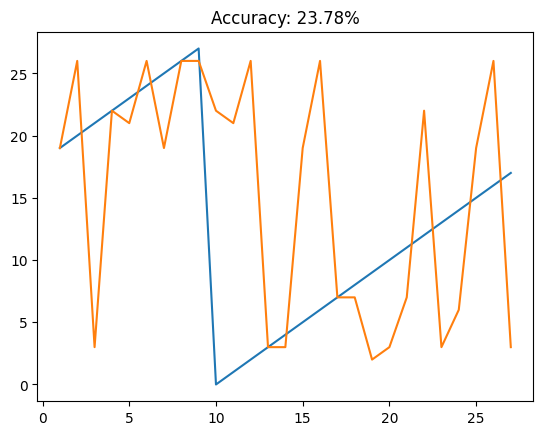

Epoch: 1
Loss: 1.7975


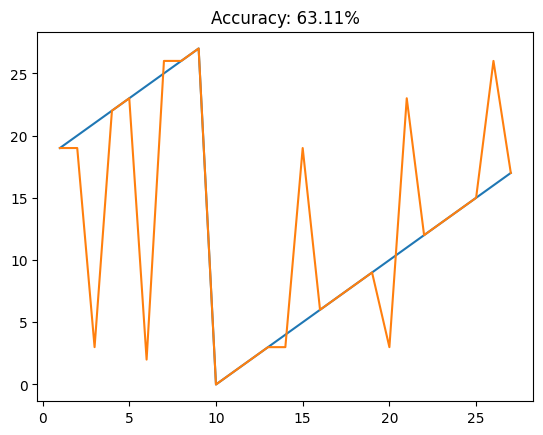

Epoch: 2
Loss: 1.2273


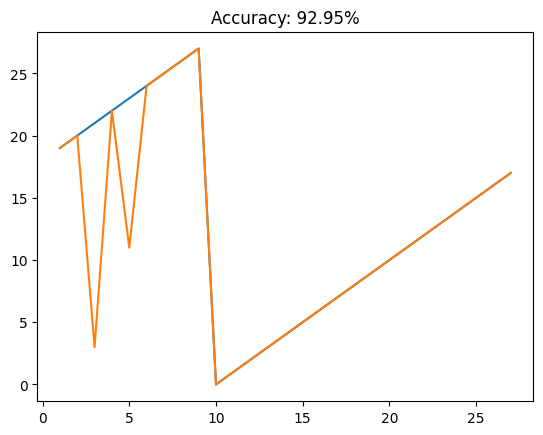

Epoch: 3
Loss: 0.9582


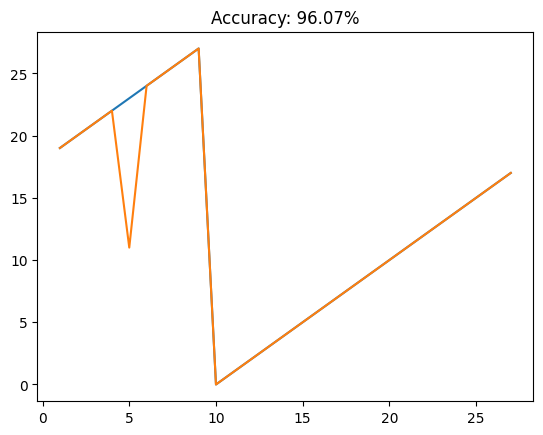

Epoch: 4
Loss: 0.5346


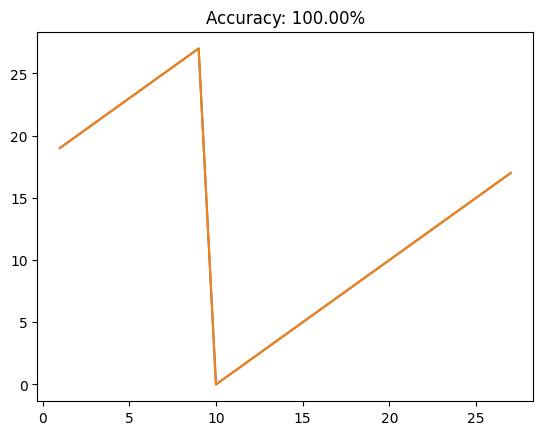

Epoch: 5
Loss: 0.4151


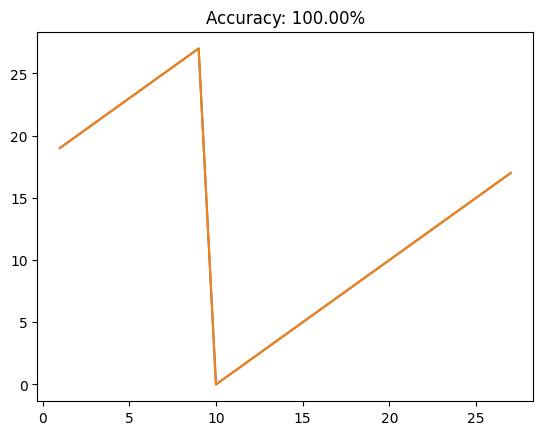

Epoch: 6
Loss: 0.3278


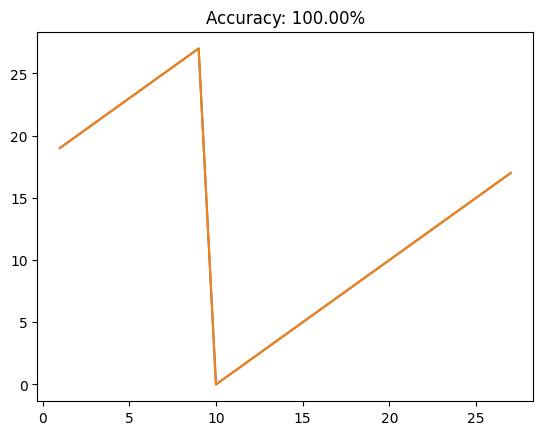

In [ ]:
k = 10
for x in range(num_epochs):
  print('Epoch: {}'.format(x))
  for encrypted, original in encrypted_dataset(num_examples, k):
    scores = model(encrypted)
    original = original.unsqueeze(1)
# Calculate loss
    loss = criterion(scores, original)
# Zero grads
    optimizer.zero_grad()
# Backpropagate
    loss.backward()
# Update weights
    optimizer.step()
  print('Loss: {:6.4f}'.format(loss.item()))

  with torch.no_grad():
    matches, total = 0, 0
    for encrypted, original in encrypted_dataset(num_examples, k):
# Compute a softmax over the outputs
      predictions = F.softmax(model(encrypted), dim=1)
# Choose the character with the maximum probability (greedy decoding)
      _, batch_out = predictions.max(dim=1)
# Remove batch
      batch_out = batch_out.squeeze(1)
# Calculate accuracy
      matches += torch.eq(batch_out, original).sum().item()
      total += torch.numel(batch_out)
    accuracy = matches / total
    plt.title('Accuracy: {:4.2f}%'.format(accuracy * 100))
    plt.plot(range(1, len(vocab)), (np.arange(1, len(vocab)) - 10) % len(vocab))
  with torch.no_grad():
    plt.plot(range(1, len(vocab)), F.softmax(model(torch.tensor(range(1,len(vocab)))), 1).max(dim=1)[1])
  plt.show()

### Анализ матриц Wih и Whh

Изучим матрицы Wih и Whh . Посчитаем нормы этих матриц:

In [ ]:
from scipy import linalg
list(map(linalg.norm, [model.rnn.weight_ih_l0.data, model.rnn.weight_hh_l0.data]))

[4.193805, 0.91608316]

Норма первой матрицы гораздо больше нормы второй матрицы.

Посмотрим на распределение модулей значений в этих матрицах
Видно, что значения первой матрицы значительно больше, чем значения второй
матрицы. Это значит, что мы при расшифровки учитываем эмбеддинг только
текущего символа, а другие символы нас не интересуют. Так получается потому, что
расшифровка идет посимвольно (расшифровка одного символа не зависит от других)
и получается, что нет зависимости между скрытыми состояниями.

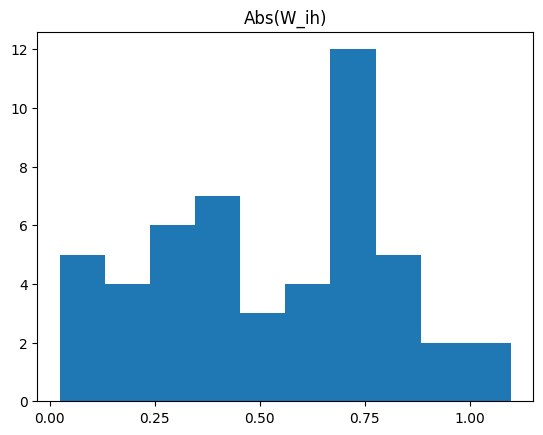

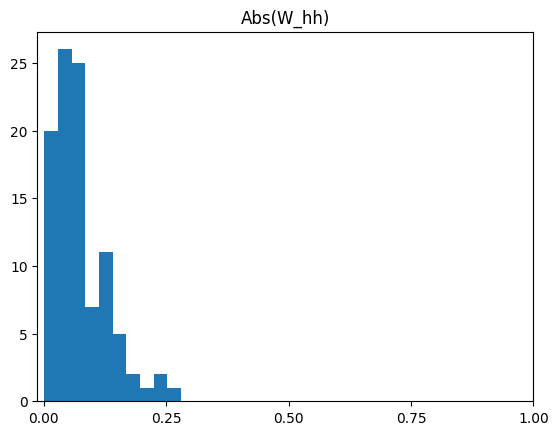

In [ ]:
W_ih = model.rnn.weight_ih_l0.data.abs().numpy().ravel()
plt.title('Abs(W_ih)')
plt.hist(W_ih)
plt.xticks(np.linspace(0, 1, 5))
plt.show()
W_hh = model.rnn.weight_hh_l0.data.abs().numpy().ravel()
plt.title('Abs(W_hh)')
plt.hist(W_hh)
plt.xticks(np.linspace(0, 1, 5))
plt.show()

### Тестирование

Проверим работу модели:

In [ ]:
key = 10
print(encrypt('RNN IS NOT AI', key))
encrypt_message= '-XXISAIXYBIKS'
encrypt_tensor = torch.tensor([vocab.index(char) for char in encrypt_message])
with torch.no_grad():
  real_tensor = model(encrypt_tensor)
  real_indexes = real_tensor.max(dim=1)[1].numpy().ravel()
  print(''.join([vocab[real_index] for real_index in real_indexes]))

-XXISAIXYBIKS
RNN IS NOT AI
